In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.formula.api as smf
import cryptofxns
import os
from os import listdir
from matplotlib import pyplot as plt
from itertools import chain
%matplotlib inline

In [2]:
MB = 1000000
hap_filter_size = 6000
HAPFILTINT = int(hap_filter_size/1000.0)
Method = '-min'
fileendname = Method +'-haplotype-k' + str(int(hap_filter_size)) + '.csv'

In [3]:
genodf = cryptofxns.geno_df;genodf.shape
centromere = cryptofxns.load_centrom_locs()
clens = cryptofxns.chromosome_lengths
tc = cryptofxns.thecol

## Load the haplotype filtered data

In [4]:
#ngenodf = pd.read_csv('../FILES/FiltGenotoHapFiltGeno2017-02-22.csv',index_col=0)
file_end = 'min-Geno-k6000.csv'
ngenodf = pd.read_csv('../FILES/FiltGenotoHapFiltGeno-%s'%file_end)

In [5]:
ngenodf.shape

(86767, 98)

In [6]:
ngenodf.head()

,Alt,Chrom,Pos,Ref,SS-B307,SS-B308,SS-B310,SS-B311,SS-B312,SS-B313,...,SS-C029_Correction,SS-C031_Correction,SS-C033,SS-C036,SS-C039,SS-C242,SS-C271,SS-C272,SS-C290,SS-C291
0,A,Chr01,5016.0,C,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
1,C,Chr01,5299.0,T,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,C,Chr01,5464.0,T,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,C,Chr01,6120.0,T,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
4,A,Chr01,6166.0,G,1,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [7]:
chrlist = np.unique(ngenodf.Chrom).tolist()
segs = [s for s in ngenodf.columns.tolist()[tc:] if s not in ['SS-A837','XL280','XL280a']];len(segs)

94

In [8]:
tetrads = cryptofxns.axalp

In [9]:
tetrads

[['SS-B869_Correction',
  'SS-B872_Correction',
  'SS-B873_Correction',
  'SS-B874_Correction'],
 ['SS-B876', 'SS-B880', 'SS-B879', 'SS-B885'],
 ['SS-B886_Correction', 'SS-B887_Correction'],
 ['SS-B890_Correction',
  'SS-B896_Correction',
  'SS-B898_Correction',
  'SS-B892_Correction',
  'SS-B901_Correction',
  'SS-B905',
  'SS-B906_Correction',
  'SS-B908_Correction'],
 ['SS-B926', 'SS-B927', 'SS-B929', 'SS-B930'],
 ['SS-B952', 'SS-B956'],
 ['SS-B960_Correction', 'SS-B961_Correction'],
 ['SS-B996', 'SS-B997', 'SS-B998'],
 ['SS-C001'],
 ['SS-C026_Correction', 'SS-C029_Correction'],
 ['SS-C031_Correction'],
 ['SS-C033', 'SS-C036', 'SS-C039'],
 ['SS-C242'],
 ['SS-C271', 'SS-C272'],
 ['SS-C273'],
 ['SS-C290', 'SS-C291']]

# Gene Conversions and Allelic Distortion

## For our bi-sexual segregants from the same basidium in "complete tetrads" we will look for evidence of allelic bias and distortion

In [10]:
full_tetrads = [tet for a,tet in enumerate(tetrads) if len(tet) >= 3]

In [11]:
full_tetrads

[['SS-B869_Correction',
  'SS-B872_Correction',
  'SS-B873_Correction',
  'SS-B874_Correction'],
 ['SS-B876', 'SS-B880', 'SS-B879', 'SS-B885'],
 ['SS-B890_Correction',
  'SS-B896_Correction',
  'SS-B898_Correction',
  'SS-B892_Correction',
  'SS-B901_Correction',
  'SS-B905',
  'SS-B906_Correction',
  'SS-B908_Correction'],
 ['SS-B926', 'SS-B927', 'SS-B929', 'SS-B930'],
 ['SS-B996', 'SS-B997', 'SS-B998'],
 ['SS-C033', 'SS-C036', 'SS-C039']]

## filter tetrads

In [12]:
segout=cryptofxns.geno_remove

In [13]:
outahere = []
for i,tet in enumerate(full_tetrads):
    for seg in tet:
        if seg in segout:
            outahere.append(i)
outa = np.unique(outahere).tolist()
outa

[1]

## We tried to add in the last tetratype. The math gets weird at the end so we'll leave it out for now.

In [14]:
complete_tetrads = [i for x,i in enumerate(full_tetrads) if x != outa[0]]
complete_tetrads = complete_tetrads #+ [['SS-B876', 'SS-B880', 'SS-B879']] ## This tetratype has two identical strains and disomy of chrom 10
complete_tetrads

[['SS-B869_Correction',
  'SS-B872_Correction',
  'SS-B873_Correction',
  'SS-B874_Correction'],
 ['SS-B890_Correction',
  'SS-B896_Correction',
  'SS-B898_Correction',
  'SS-B892_Correction',
  'SS-B901_Correction',
  'SS-B905',
  'SS-B906_Correction',
  'SS-B908_Correction'],
 ['SS-B926', 'SS-B927', 'SS-B929', 'SS-B930'],
 ['SS-B996', 'SS-B997', 'SS-B998'],
 ['SS-C033', 'SS-C036', 'SS-C039']]

In [15]:
tetraddfs = [ngenodf[ngenodf.columns.tolist()[:tc] + ctet].dropna(axis=0,how='any').reset_index(drop=True).copy() for ctet in complete_tetrads]

In [16]:
for a in range(len(tetraddfs)):
    temp = tetraddfs[a]
    segs = temp.columns.tolist()[4:]
    assert len(segs) == len(complete_tetrads[a])
    denom = float([4 if len(complete_tetrads[a]) <= 4 else len(complete_tetrads[a])][0])
    AF = np.array(temp.ix[:,tc:].sum(axis=1).tolist())/denom
    temp['AF'] = AF

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [17]:
tetraddfs[-1].head()

,Alt,Chrom,Pos,Ref,SS-C033,SS-C036,SS-C039,AF
0,A,Chr01,5016.0,C,1,0,1,0.5
1,C,Chr01,5299.0,T,1,0,1,0.5
2,C,Chr01,5464.0,T,1,0,1,0.5
3,C,Chr01,6120.0,T,1,0,1,0.5
4,A,Chr01,6166.0,G,1,0,1,0.5


## Visulalize what Allelic distortion and gene conversions look like

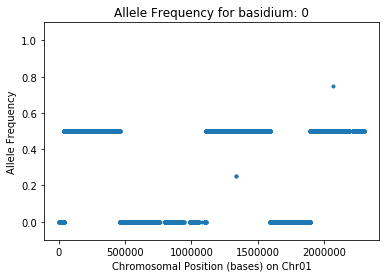

In [18]:
CHR = 'Chr01'
k = 0
plt.plot(tetraddfs[k].Pos[tetraddfs[k].Chrom==CHR],tetraddfs[k].AF[tetraddfs[k].Chrom==CHR],'.');
plt.ylim(-0.1,1.1);plt.xlabel('Chromosomal Position (bases) on %s'%CHR);plt.ylabel('Allele Frequency');
plt.title('Allele Frequency for basidium: %s'%k);

# Labeling and finding allelic distortions and gene conversions 

In [19]:
for i,df in enumerate(tetraddfs):
    temp = []
    dfin = df.index.tolist()
    thesegs = df.columns[4:-1]
    if len(thesegs) == 4:
        for j in dfin:
            if df['AF'][j] == 0.0:
                temp.append('zero')
            elif df['AF'][j] == 1.0:
                temp.append('one')
            elif df['AF'][j] in [.25,.75]:
                temp.append('gc')
            elif df['AF'][j] == .5:
                temp.append(0)
            else:
                print df['AF'][j]
        df['LOH'] = temp
    if len(thesegs) == 8:
        for j in dfin:
            if df['AF'][j] == 0:
                temp.append('zero')
            elif df['AF'][j] == 1.0:
                temp.append('one')
            elif (df['AF'][j] != 0.5) and (df['AF'][j] not in [0.0,1.0]):
                temp.append('gc')
            elif df['AF'][j] == .5:
                temp.append(0)
            else:
                print df['AF'][j]
        df['LOH'] = temp
    if len(thesegs) == 3:
        for j in dfin:
            if df['AF'][j] == 0.0:
                temp.append('zero')
            elif df['AF'][j] == .75:
                temp.append('one')
            elif df['AF'][j] in [.5,.25]:
                temp.append(0)
            else:
                print df['AF'][j],len(thesegs)
        df['LOH'] = temp

In [20]:
tetraddfs[0].head()

,Alt,Chrom,Pos,Ref,SS-B869_Correction,SS-B872_Correction,SS-B873_Correction,SS-B874_Correction,AF,LOH
0,A,Chr01,5016.0,C,0,0,0,0,0.0,zero
1,C,Chr01,5299.0,T,0,0,0,0,0.0,zero
2,C,Chr01,5464.0,T,0,0,0,0,0.0,zero
3,C,Chr01,6120.0,T,0,0,0,0,0.0,zero
4,A,Chr01,6166.0,G,0,0,0,0,0.0,zero


In [21]:
tetraddfs[-1][tetraddfs[-1].Chrom=='Chr10'].tail()

,Alt,Chrom,Pos,Ref,SS-C033,SS-C036,SS-C039,AF,LOH
15633,C,Chr10,1074868.0,G,1,0,0,0.25,0
15634,T,Chr10,1075135.0,A,1,0,0,0.25,0
15635,T,Chr10,1075209.0,C,1,0,0,0.25,0
15636,T,Chr10,1075633.0,C,1,0,0,0.25,0
15637,T,Chr10,1076004.0,C,1,0,0,0.25,0


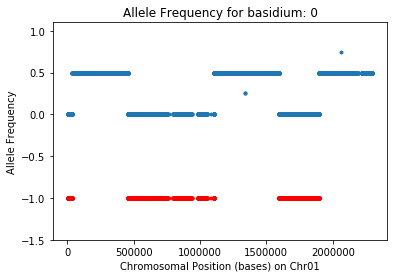

In [22]:
CHR = 'Chr01'
k = 0
plt.plot(tetraddfs[k].Pos[tetraddfs[k].Chrom==CHR],tetraddfs[k].AF[tetraddfs[k].Chrom==CHR],'.');
plt.plot(tetraddfs[k][(tetraddfs[k].Chrom==CHR)&(tetraddfs[k]['LOH']=='zero')]['Pos'],
         np.zeros(len(tetraddfs[k].Pos[(tetraddfs[k].Chrom==CHR)&(tetraddfs[k]['LOH']=='zero')]))-1,'r.');
plt.ylim(-1.5,1.1);plt.xlabel('Chromosomal Position (bases) on %s'%CHR);plt.ylabel('Allele Frequency');
plt.title('Allele Frequency for basidium: %s'%k);

In [23]:
[s for s in tetraddfs[1].LOH.unique() if type(s) != int]

['gc', 'zero', 'one']

In [24]:
def LOH_regions(tetdfs,thestate=['gc','zero','one'],distance=1):
    Chrlist = sorted(tetdfs[0].Chrom.unique().tolist());assert len(Chrlist) == 14;
    newdf = pd.DataFrame(columns=Chrlist,index=range(len(tetdfs)))
    gtdf = pd.DataFrame(columns=Chrlist,index=range(len(tetdfs)))
    posdf = pd.DataFrame(columns=Chrlist,index=range(len(tetdfs)))
    for d,df in enumerate(tetdfs):
        for chrom in Chrlist:
            sub = df[df.Chrom==chrom];
            if len(sub) == 0:
                print "Bad Chrom",d
            states =  thestate
            width = []
            gt = []
            poss = []
            for state in states:
                posin = sub.Pos[sub['LOH']==state].index.tolist();
                if len(posin) == 0:
                    width.append([])
                    gt.append([])
                    poss.append([])
                    continue
                regionin = [];
                regionin.append(0)
                for i in range(len(posin)-1):
                    if posin[i+1] - posin[i] > distance:
                        regionin.append(i+1)
                    else:
                        pass
                regionin.append(len(posin))
                statepos = [(sub.Pos[posin[regionin[i]]],sub.Pos[posin[regionin[i+1]-1]]) for i in range(len(regionin)-1)]
                statewidth = [sub.Pos[posin[regionin[i+1]-1]] - sub.Pos[posin[regionin[i]]] - 1.0 for i in range(len(regionin)-1)]
                stategt = [ sub.ix[posin[regionin[i]],sub.columns[4:-2]].sum() for i in range(len(regionin)-1)]
                width.append([w for w in statewidth if w > 0]);
                gtin = [g for g, w in enumerate(statewidth) if w > 0]
                gt.append([stategt[g] for g in gtin])
                poss.append([statepos[g] for g in gtin])
            newdf[chrom][d] = width
            gtdf[chrom][d] = gt
            posdf[chrom][d] = poss
    return newdf,gtdf,posdf

In [25]:
widths_df = LOH_regions(tetraddfs)

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [26]:
1337833.0 - 1337731.0

102.0

In [27]:
widths_df[0].ix[1,'Chr02']

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


[[13191.0, 96.0, 97355.0, 35227.0, 62631.0, 371980.0, 35327.0], [433558.0], []]

In [28]:
widths_df[1].ix[1,'Chr02']

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


[[3, 3, 5, 3, 3, 3, 3], [0], []]

In [29]:
widths_df[2].ix[0,:]

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Chr01    [[(1337731.0, 1337833.0)], [(5016.0, 39118.0),...
Chr02    [[], [(2458.0, 546981.0), (975583.0, 1623022.0...
Chr03    [[(1359227.0, 1359616.0)], [(9636.0, 495876.0)...
Chr04                       [[], [(7357.0, 710054.0)], []]
Chr05    [[(970398.0, 970573.0), (1372457.0, 1375196.0)...
Chr06                      [[], [(9790.0, 1413156.0)], []]
Chr07                       [[], [(2180.0, 744569.0)], []]
Chr08    [[], [(147299.0, 244361.0), (930347.0, 995967....
Chr09                     [[], [(260673.0, 705930.0)], []]
Chr10    [[(893712.0, 893725.0)], [(5073.0, 370966.0)],...
Chr11                     [[], [(751568.0, 947885.0)], []]
Chr12                     [[], [(210606.0, 904913.0)], []]
Chr13                      [[], [(84787.0, 772362.0)], []]
Chr14    [[(668080.0, 668927.0)], [(669038.0, 745415.0)...
Name: 0, dtype: object

In [30]:
widths_df[0].ix[2,:]

Chr01    [[138.0, 8.0], [363850.0, 280189.0], []]
Chr02                        [[], [433558.0], []]
Chr03                   [[265.0], [], [148067.0]]
Chr04           [[158.0], [613052.0], [107820.0]]
Chr05           [[117.0, 3322.0], [], [187844.0]]
Chr06                    [[32.0], [551667.0], []]
Chr07                   [[879.0], [229407.0], []]
Chr08                 [[86.0, 23.0], [], [581.0]]
Chr09            [[25.0], [258426.0], [313542.0]]
Chr10                             [[6.0], [], []]
Chr11                                [[], [], []]
Chr12    [[26359.0, 23.0, 533.0], [245883.0], []]
Chr13                        [[], [335495.0], []]
Chr14               [[], [], [485780.0, 76691.0]]
Name: 2, dtype: object

In [31]:
widths_df[0].ix[0,:]

Chr01    [[101.0], [34101.0, 647301.0, 301162.0], []]
Chr02                  [[], [544522.0, 647438.0], []]
Chr03             [[388.0], [486239.0, 588237.0], []]
Chr04                            [[], [702696.0], []]
Chr05     [[174.0, 2738.0], [129527.0, 131003.0], []]
Chr06                           [[], [1403365.0], []]
Chr07                            [[], [742388.0], []]
Chr08                    [[], [97061.0, 65619.0], []]
Chr09                            [[], [445256.0], []]
Chr10                        [[12.0], [365892.0], []]
Chr11                            [[], [196316.0], []]
Chr12                            [[], [694306.0], []]
Chr13                            [[], [687574.0], []]
Chr14                        [[846.0], [76376.0], []]
Name: 0, dtype: object

In [32]:
widths_df[2]

,Chr01,Chr02,Chr03,Chr04,Chr05,Chr06,Chr07,Chr08,Chr09,Chr10,Chr11,Chr12,Chr13,Chr14
0,"[[(1337731.0, 1337833.0)], [(5016.0, 39118.0),...","[[], [(2458.0, 546981.0), (975583.0, 1623022.0...","[[(1359227.0, 1359616.0)], [(9636.0, 495876.0)...","[[], [(7357.0, 710054.0)], []]","[[(970398.0, 970573.0), (1372457.0, 1375196.0)...","[[], [(9790.0, 1413156.0)], []]","[[], [(2180.0, 744569.0)], []]","[[], [(147299.0, 244361.0), (930347.0, 995967....","[[], [(260673.0, 705930.0)], []]","[[(893712.0, 893725.0)], [(5073.0, 370966.0)],...","[[], [(751568.0, 947885.0)], []]","[[], [(210606.0, 904913.0)], []]","[[], [(84787.0, 772362.0)], []]","[[(668080.0, 668927.0)], [(669038.0, 745415.0)..."
1,"[[(38724.0, 135545.0), (499845.0, 764786.0), (...","[[(2458.0, 15650.0), (17320.0, 17417.0), (7181...","[[(25768.0, 225976.0), (314202.0, 479379.0), (...","[[(7357.0, 55178.0), (426130.0, 429067.0), (10...","[[(91969.0, 290551.0), (291356.0, 375692.0), (...","[[(9790.0, 37853.0), (41011.0, 47089.0), (5992...","[[(458608.0, 459913.0), (734670.0, 734729.0), ...","[[(262283.0, 677836.0), (686352.0, 687333.0), ...","[[(414735.0, 417435.0), (473153.0, 706253.0), ...","[[(5073.0, 45856.0), (46947.0, 294558.0), (364...","[[(422.0, 233063.0), (291378.0, 438921.0), (45...","[[(207071.0, 361894.0), (608447.0, 821412.0), ...","[[(10809.0, 25381.0), (25872.0, 81382.0), (856...","[[(6648.0, 31161.0), (662814.0, 668231.0)], []..."
2,"[[(1597830.0, 1597969.0), (1896168.0, 1896177....","[[], [(75832.0, 509391.0)], []]","[[(1618919.0, 1619185.0)], [], [(1952764.0, 21...","[[(1296926.0, 1297085.0)], [(429748.0, 1042801...","[[(224848.0, 224966.0), (1282365.0, 1285688.0)...","[[(703360.0, 703393.0)], [(47283.0, 598951.0)]...","[[(231816.0, 232696.0)], [(2180.0, 231588.0)],...","[[(272865.0, 272952.0), (694504.0, 694528.0)],...","[[(873211.0, 873237.0)], [(920001.0, 1178428.0...","[[(725924.0, 725931.0)], [], []]","[[], [], []]","[[(36534.0, 62894.0), (312446.0, 312470.0), (7...","[[], [(436866.0, 772362.0)], []]","[[], [], [(33642.0, 519423.0), (668723.0, 7454..."
3,"[[], [(42336.0, 480737.0), (745866.0, 1450445....","[[], [(122692.0, 849555.0), (1177096.0, 162302...","[[], [(9636.0, 314205.0), (961494.0, 2100832.0...","[[], [(199523.0, 891848.0), (1673445.0, 178285...","[[], [(21402.0, 206679.0), (742499.0, 1068613....","[[], [(46723.0, 745833.0), (1087700.0, 1160705...","[[], [(2180.0, 1339632.0)], []]","[[], [(65474.0, 146304.0), (681102.0, 1191613....","[[], [(153.0, 71378.0)], []]","[[], [(189541.0, 1076004.0)], []]","[[], [(101253.0, 724731.0)], []]","[[], [(36534.0, 565719.0)], []]","[[], [(10809.0, 64078.0), (208683.0, 208914.0)...","[[], [(6648.0, 216254.0)], []]"
4,"[[], [(36573.0, 820616.0), (1598374.0, 1598555...","[[], [(249040.0, 672303.0)], [(2458.0, 80869.0...","[[], [(954967.0, 1204556.0), (1515668.0, 16559...","[[], [(708737.0, 708925.0)], []]","[[], [], [(208653.0, 718288.0)]]","[[], [(1157256.0, 1408584.0)], [(9790.0, 51666...","[[], [(228713.0, 735617.0), (1101035.0, 130904...","[[], [(1032431.0, 1191613.0)], [(262283.0, 464...","[[], [(1081403.0, 1178428.0)], [(153.0, 44462....","[[], [(316127.0, 702288.0)], [(5073.0, 49237.0)]]","[[], [(608536.0, 702735.0)], [(745699.0, 10174...","[[], [(207071.0, 823667.0)], []]","[[], [], [(10809.0, 85010.0)]]","[[], [(674103.0, 745415.0)], []]"


## Analysis of allelic Distortion
### Investigating common positions

In [33]:
allelic_dis_poss = widths_df[2]

In [34]:
allelic_dis_poss['Chr01']

0    [[(1337731.0, 1337833.0)], [(5016.0, 39118.0),...
1    [[(38724.0, 135545.0), (499845.0, 764786.0), (...
2    [[(1597830.0, 1597969.0), (1896168.0, 1896177....
3    [[], [(42336.0, 480737.0), (745866.0, 1450445....
4    [[], [(36573.0, 820616.0), (1598374.0, 1598555...
Name: Chr01, dtype: object

# Analysis of allelic Distortion

## Make dataframe with allelic distortions (greater than one base)

In [35]:
allelic_distortion = widths_df[0]
allelic_distortion.ix[0,:].head()

Chr01    [[101.0], [34101.0, 647301.0, 301162.0], []]
Chr02                  [[], [544522.0, 647438.0], []]
Chr03             [[388.0], [486239.0, 588237.0], []]
Chr04                            [[], [702696.0], []]
Chr05     [[174.0, 2738.0], [129527.0, 131003.0], []]
Name: 0, dtype: object

## Distributions of size of alleic distortion

In [36]:
allelic_distortion_chrom = []
for chrom in chrlist:
    allelic_distortion_chrom.append(
    np.log10(np.concatenate(list(chain.from_iterable(allelic_distortion[chrom].tolist())))).tolist())

In [37]:
len(allelic_distortion_chrom)

14

## Are the distributions of number in LOH per chrom normal?

In [38]:
for i,a in enumerate(allelic_distortion_chrom):
    pval = ss.mstats.normaltest([10**b for b in a])[1]
    if pval < (0.05/14):
        print chrlist[i]

Chr03
Chr07


/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:2237: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  np.min(n))
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:2237: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:2237: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  np.min(n))
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:2237: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  np.min(n))
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:2237: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  np.min(n))
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:2237: UserWarning: kurtosistest only valid for n>=20 ...

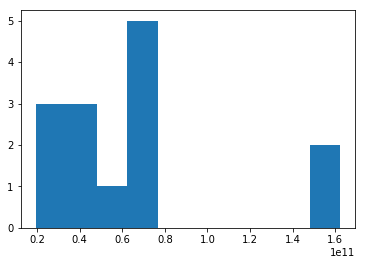

In [39]:
plt.hist([np.var([10**b for b in a],ddof=1) for i,a in enumerate(allelic_distortion_chrom)]);

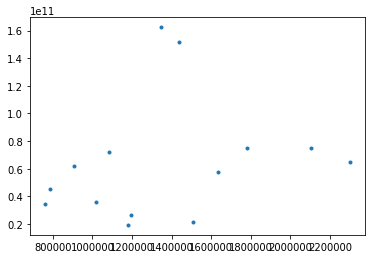

In [40]:
plt.plot(clens,[np.var([10**b for b in a],ddof=1) for i,a in enumerate(allelic_distortion_chrom)],'.');

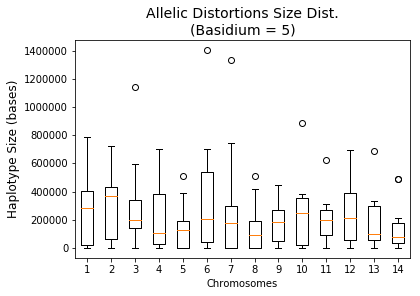

In [41]:
plt.boxplot([[10**b for b in a ] for a in allelic_distortion_chrom]);
plt.title('Allelic Distortions Size Dist.\n(Basidium = %s)'%len(complete_tetrads),fontsize=14);
plt.xlabel('Chromosomes');
plt.ylabel('Haplotype Size (bases)',fontsize=12);

## Count the number of areas in allelic distortion

In [42]:
allelic_distortion['Chr01'][0][1]

[34101.0, 647301.0, 301162.0]

In [43]:
N_allelic_distortion = pd.DataFrame(index=allelic_distortion.index.tolist(),columns=chrlist);
for chrom in chrlist:
    for i in N_allelic_distortion.index.tolist():
        N_allelic_distortion[chrom][i] = len(np.concatenate(allelic_distortion[chrom][i]))

In [44]:
N_allelic_distortion

,Chr01,Chr02,Chr03,Chr04,Chr05,Chr06,Chr07,Chr08,Chr09,Chr10,Chr11,Chr12,Chr13,Chr14
0,4,2,3,1,4,1,1,2,1,2,1,1,1,2
1,7,8,7,7,7,5,5,5,6,5,5,4,4,4
2,4,1,2,3,3,2,2,3,3,1,0,4,1,2
3,3,2,2,3,3,3,1,2,1,1,1,1,3,1
4,5,4,5,1,1,3,3,2,3,2,2,1,1,1


In [45]:
N_allelic_distortion_0 = pd.DataFrame(index=allelic_distortion.index.tolist(),columns=chrlist);
for chrom in chrlist:
    for i in N_allelic_distortion_0.index.tolist():
        zeros = widths_df[1][chrom][i][1]
        if i == 1:
            zgc = [gc for gc in widths_df[1][chrom][i][0] if gc < 4]
        else:
            zgc = [gc for gc in widths_df[1][chrom][i][0] if gc < 2]
        N_allelic_distortion_0[chrom][i] = len(zeros)  + len(zgc)

In [46]:
N_allelic_distortion_0

,Chr01,Chr02,Chr03,Chr04,Chr05,Chr06,Chr07,Chr08,Chr09,Chr10,Chr11,Chr12,Chr13,Chr14
0,4,2,2,1,3,1,1,2,1,2,1,1,1,2
1,4,7,3,4,5,3,2,2,3,1,4,4,2,1
2,3,1,0,1,1,1,2,0,1,0,0,3,1,0
3,3,2,2,2,3,3,1,2,1,1,1,1,3,1
4,2,1,2,1,0,1,2,1,1,1,1,1,0,1


In [47]:
for chrom in chrlist:
    for i in N_allelic_distortion_0.index.tolist():
        assert N_allelic_distortion_0[chrom][i] <= N_allelic_distortion[chrom][i]

In [48]:
precet_0_ad = np.array(N_allelic_distortion_0.sum(axis=0))/np.array(N_allelic_distortion.sum(axis=0))

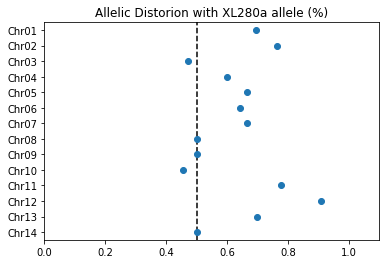

In [49]:
fig,ax=plt.subplots(1,1);
plt.yticks(range(14));
ax.set_yticklabels(list(reversed(chrlist)));
ax.plot(list(reversed(precet_0_ad)),range(14),'o')
ax.set_xlim(0,1);
ax.set_title('Allelic Distorion with XL280a allele (%)');
ax.vlines(x=.5,ymin=-1,ymax=14,linestyles='--');
ax.set_ylim(-.5,13.5);
ax.set_xlim(0,1.1);

## Count LOH due to possible GC (the first filed).

In [50]:
allelic_distortion['Chr01'][0][0]

[101.0]

In [51]:
N_loh_gc = pd.DataFrame(index=allelic_distortion.index.tolist(),columns=chrlist);
for chrom in chrlist:
    for i in N_loh_gc.index.tolist():
        N_loh_gc[chrom][i] = len(allelic_distortion[chrom][i][0])

In [52]:
total_n_gc = N_loh_gc.sum().sum();

In [53]:
total_n_loh = N_allelic_distortion.sum().sum()

In [54]:
total_n_gc

83.0

In [55]:
total_n_loh

197.0

In [56]:
print total_n_gc/total_n_loh

0.421319796954


## Display distributions of allelic distortion per chromosome

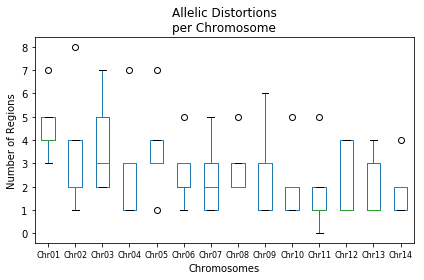

In [57]:
N_allelic_distortion.plot(kind='box');
plt.tick_params(axis='x', which='major', labelsize=8);
plt.title('Allelic Distortions\nper Chromosome');
plt.ylabel('Number of Regions');
plt.xlabel('Chromosomes');plt.tight_layout();
plt.savefig('../FIGS/Chrom-Dist-Allelic-Distortion-Feb-2017.jpeg');

## Regression analysis of allelic distortion

### concatinate dataframe fro allelic distortion size and chromosome length

In [58]:
Clens_List = []
Chrom_List = []
for i,chrom in enumerate(chrlist):
    Clens_List.append([float(clens[i]) for j in range(N_allelic_distortion[chrom].sum())])
    Chrom_List.append([chrom for j in range(N_allelic_distortion[chrom].sum())])
Clens_list = np.concatenate(Clens_List).tolist()
#Chrom_list = np.concatenate(Chrom_List).tolist()
#Allelic_Distorion_list = np.concatenate(allelic_distortion_chrom).tolist()
Allelic_Distorion_list = np.concatenate([[10**b for b in a ] for a in allelic_distortion_chrom]).tolist()
allelic_distortion_chrom_df = pd.DataFrame([Clens_list,Allelic_Distorion_list]).T#[Chrom_list,Clens_list,Allelic_Distorion_list]).T
#allelic_distortion_chrom_df.columns=['Clens','Log10HS']#['Chrom','Clens','Log10HS']
allelic_distortion_chrom_df.columns=['Clens','Size']
allelic_distortion_chrom_df.tail()

,Clens,Size
192,762695.0,76691.0
193,762695.0,485780.0
194,762695.0,76691.0
195,762695.0,209605.0
196,762695.0,71311.0


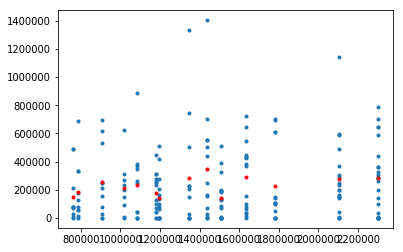

In [59]:
plt.plot(allelic_distortion_chrom_df.Clens,allelic_distortion_chrom_df.Size,'.')
plt.plot(allelic_distortion_chrom_df.Clens.unique().tolist(),
         [np.mean(allelic_distortion_chrom_df.Size[allelic_distortion_chrom_df.Clens==CL].tolist()) 
         for CL in allelic_distortion_chrom_df.Clens.unique().tolist()],'r.');

plt.plot(allelic_distortion_chrom_df.Clens,allelic_distortion_chrom_df.Log10HS,'.')
plt.plot(allelic_distortion_chrom_df.Clens.unique().tolist(),
         [np.mean(allelic_distortion_chrom_df.Log10HS[allelic_distortion_chrom_df.Clens==CL].tolist()) 
         for CL in allelic_distortion_chrom_df.Clens.unique().tolist()],'r.');

### ANOVA on distortion size and chromosome length

/Users/croth/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


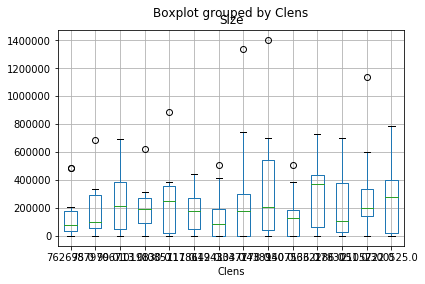

In [60]:
allelic_distortion_chrom_df.boxplot('Size',by='Clens');

In [61]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('Size ~ Clens', data= allelic_distortion_chrom_df).fit()

aov_table = sm.stats.anova_lm(mod)
print aov_table

/Users/croth/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


             df        sum_sq       mean_sq         F    PR(>F)
Clens       1.0  1.821872e+11  1.821872e+11  2.861057  0.092345
Residual  195.0  1.241727e+13  6.367828e+10       NaN       NaN


/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [62]:
#results = smf.ols(formula='Log10HS ~ Clens',data=allelic_distortion_chrom_df).fit();
results = smf.ols(formula='Size~ Clens',data=allelic_distortion_chrom_df).fit();

In [63]:
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                   Size   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.861
Date:                Thu, 08 Feb 2018   Prob (F-statistic):             0.0923
Time:                        14:47:01   Log-Likelihood:                -2728.9
No. Observations:                 197   AIC:                             5462.
Df Residuals:                     195   BIC:                             5468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.388e+05   5.86e+04      2.367      0.0

#### concatinate dataframe for allelic distortion occurance and chromosome length

In [64]:
N_allelic_distortion['Chr14']

0    2
1    4
2    2
3    1
4    1
Name: Chr14, dtype: object

In [65]:
clensdf = pd.DataFrame([clens for i in N_allelic_distortion.index.tolist()],columns=chrlist) ## A dataframe with chromlengths
clens_lists = np.concatenate([clensdf[chrom].tolist() for chrom in chrlist]);
aldis_lists = np.concatenate([N_allelic_distortion[chrom].tolist() for chrom in chrlist]);
allel_distor_df = pd.DataFrame([clens_lists,aldis_lists]).T;
allel_distor_df.columns=['Chrlen','N'];
allel_distor_df.head()

,Chrlen,N
0,2300525,4
1,2300525,7
2,2300525,4
3,2300525,3
4,2300525,5


In [66]:
allel_distor_df.tail()

,Chrlen,N
65,762695,2
66,762695,4
67,762695,2
68,762695,1
69,762695,1


In [67]:
allel_distor_df.N.sum()

197L

In [68]:
log_allele_df = pd.DataFrame(index=range(len(clens)))
log_allele_df['Chrom'] = chrlist
log_allele_df['Chrlen'] = clens
log_allele_df['EN'] = [allel_distor_df.N[allel_distor_df.Chrlen==clen].mean() 
                       for clen in clens]
log_allele_df['LogEN'] = [np.log(allel_distor_df.N[allel_distor_df.Chrlen==clen].mean()) 
                          for clen in clens]
log_allele_df['Var'] = [np.var(allel_distor_df.N[allel_distor_df.Chrlen==clen],ddof=1) 
                        for clen in clens]
log_allele_df['Disp'] = [log_allele_df.EN[i]/log_allele_df.Var[i] for i in range(len(clens))]

In [69]:
log_allele_df

,Chrom,Chrlen,EN,LogEN,Var,Disp
0,Chr01,2300525,4.6,1.526056,2.3,2.000000
1,Chr02,1632286,3.4,1.223775,7.8,0.435897
2,Chr03,2105722,3.8,1.335001,4.7,0.808511
3,Chr04,1783051,3.0,1.098612,6.0,0.500000
4,Chr05,1507536,3.6,1.280934,4.8,0.750000
5,Chr06,1438940,2.8,1.029619,2.2,1.272727
6,Chr07,1347778,2.4,0.875469,2.8,0.857143
7,Chr08,1194303,2.8,1.029619,1.7,1.647059
8,Chr09,1178642,2.8,1.029619,4.2,0.666667
9,Chr10,1085711,2.2,0.788457,2.7,0.814815


In [70]:
log_allele_df.to_csv('../FILES/Crypto-09-Log-Allele-Distortion-Sep2017.csv')

### fit linear model to investigate relathionship between occurance and chrom length

In [71]:
Fitresult = smf.ols(formula = 'N ~ Chrlen ',data=allel_distor_df).fit();print Fitresult.summary();mypvalu1 = Fitresult.pvalues[1]

                            OLS Regression Results                            
Dep. Variable:                      N   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     11.97
Date:                Thu, 08 Feb 2018   Prob (F-statistic):           0.000938
Time:                        14:47:02   Log-Likelihood:                -136.57
No. Observations:                  70   AIC:                             277.1
Df Residuals:                      68   BIC:                             281.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6649      0.655      1.016      0.3

In [72]:
Fitresult.conf_int().T.Chrlen * MB

0    0.668453
1    2.490522
Name: Chrlen, dtype: float64

In [73]:
Fitresult.params.Intercept

0.66486136564248088

In [74]:
Fitresult.params.Chrlen * MB

1.5794875788849239

In [75]:
Fitresult.pvalues

Intercept    0.313454
Chrlen       0.000938
dtype: float64

## Fit Log-Linear Model: Log E[ N ] to chromosome length

In [76]:
log_allele_df.head()

,Chrom,Chrlen,EN,LogEN,Var,Disp
0,Chr01,2300525,4.6,1.526056,2.3,2.000000
1,Chr02,1632286,3.4,1.223775,7.8,0.435897
2,Chr03,2105722,3.8,1.335001,4.7,0.808511
3,Chr04,1783051,3.0,1.098612,6.0,0.500000
4,Chr05,1507536,3.6,1.280934,4.8,0.750000


In [77]:
Fitresult_log = smf.ols(formula = 'LogEN ~ Chrlen ',data=log_allele_df).fit();
print Fitresult_log.summary();mypvalu2 = Fitresult_log.pvalues[1];print mypvalu2

                            OLS Regression Results                            
Dep. Variable:                  LogEN   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     58.05
Date:                Thu, 08 Feb 2018   Prob (F-statistic):           6.18e-06
Time:                        14:47:02   Log-Likelihood:                 11.003
No. Observations:                  14   AIC:                            -18.01
Df Residuals:                      12   BIC:                            -16.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2687      0.101      2.662      0.0

/Users/croth/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


In [78]:
Fitresult_log.pvalues

Intercept    0.020696
Chrlen       0.000006
dtype: float64

### Make regression line

In [79]:
x_range = range(0,max(clens)+MB/2,MB/2)
Reg = [Fitresult.params[1]*x + Fitresult.params[0] for x in x_range]

## Plot results & save

In [80]:
clens

[2300525,
 1632286,
 2105722,
 1783051,
 1507536,
 1438940,
 1347778,
 1194303,
 1178642,
 1085711,
 1019830,
 906713,
 787979,
 762695]

In [81]:
allel_distor_df.N[allel_distor_df['Chrlen']==clens[11]].sum()

11L

In [82]:
from matplotlib import gridspec

In [83]:
precet_0_ad

array([ 0.69565217,  0.76470588,  0.47368421,  0.6       ,  0.66666667,
        0.64285714,  0.66666667,  0.5       ,  0.5       ,  0.45454545,
        0.77777778,  0.90909091,  0.7       ,  0.5       ])

In [84]:
len(allelic_distortion_chrom)

14

In [85]:
len(allelic_distortion_chrom[11])

11

In [86]:
len(allelic_distortion_chrom_df[allelic_distortion_chrom_df.Clens==clens[11]])

11

In [87]:
10/11.0

0.9090909090909091

In [88]:
allelic_distortion_chrom_df['Chrom'] = [ chrlist[clens.index(clen)] for clen in allelic_distortion_chrom_df.Clens.tolist()]
allelic_distortion_chrom_df['Chromn'] = [ clens.index(clen)+1 for clen in allelic_distortion_chrom_df.Clens.tolist()]
allelic_distortion_chrom_df['log10'] = np.log10(allelic_distortion_chrom_df['Size'].values)

In [89]:
import seaborn as sns
sns.set()

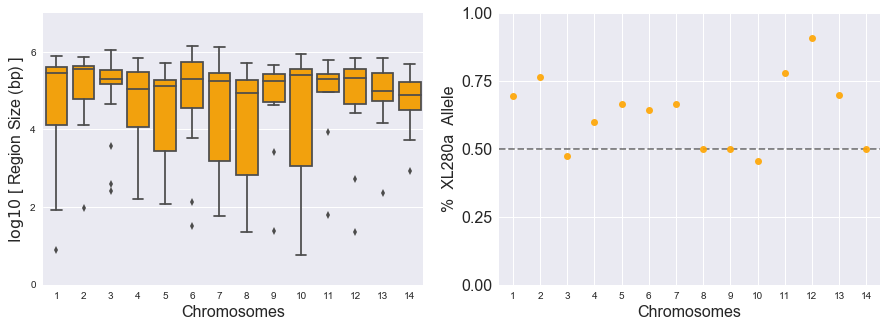

In [90]:
fig, ax = plt.subplots(1,2,figsize=(15,5));
sns.set(font_scale=2.0)
plt.sca(ax.ravel()[0]);
sns.boxplot(x='Chromn',y='log10',data=allelic_distortion_chrom_df,color='orange',saturation=0.9);
plt.ylim(0,7);plt.xlabel('Chromosomes',fontsize=16);
plt.ylabel("$\log10$ [ Region Size (bp) ]",fontsize=16);
plt.sca(ax.ravel()[1]);plt.ylim(0,1);plt.xticks(np.arange(1,15,1));
plt.xlabel('Chromosomes',fontsize=16);
plt.ylabel('%  XL280a  Allele',fontsize=16);
plt.yticks([0,0.25,0.50,0.75,1.0],fontsize=16)
plt.plot(np.arange(1,15,1),precet_0_ad,'o',color='orange',alpha=.9);
plt.hlines(y=.5,xmin=.5,xmax=14.5,linestyles='--',alpha=.5);
plt.xlim(.5,14.5)
plt.subplots_adjust(hspace=0.40);
##fig.savefig('../FIGS/Crypto-LOH-Allelic-Distor-Jan2018.png',dpi=900);
#fig.savefig('../FIGS/Crypto-09-LOH-Allelic-Distor-Feb2018.pdf',dpi=1200);

fig, ax = plt.subplots(1,2,figsize=(10,4))
#gs = gridspec.GridSpec(1,2, width_ratios=[2,1]);
plt.sca(ax.ravel()[0])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.boxplot(allelic_distortion_chrom,positions=np.arange(1,15,1))#,
                   # capprops={'color':'None'},
                    #medianprops={'color':'orange','alpha':.9}); 
plt.tick_params(axis='x', which='major', labelsize=8);
plt.xlabel('Chromosomes',fontsize=12);
plt.ylabel('$\log_{10}\,$ Haplotype Size (bases)',fontsize=12);
plt.ylim(0,7);plt.tight_layout();

plt.sca(ax.ravel()[1])
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
#plt.gca().set_xticklabels([0,.5,1],fontsize=10)
#plt.gca().set_xticklabels(np.arange(1,15,1),fontsize=12);
plt.plot(np.arange(1,15,1),list(reversed(precet_0_ad)),'o',color='orange',alpha=.9);
#plt.hlines(y=.5,xmin=-1,xmax=14,linestyles='--',alpha=.5)
plt.subplots_adjust(hspace=0.30)
plt.gca().set_xticklabels(np.arange(1,15,1),fontsize=10)
plt.ylabel('% XL280a Allele',fontsize=12);
plt.xlabel('Chromosomes');
#fig.savefig('../FIGS/Crypto-LOH-Allelic-Distor-Aug2017.png',dpi=900);

In [91]:
len(precet_0_ad)

14

In [92]:
np.arange(1,15,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

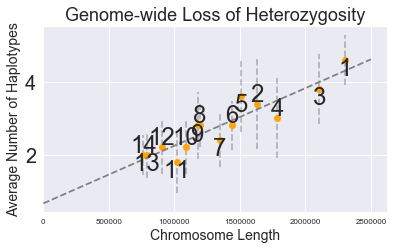

In [93]:
plt.plot(clens,[np.mean(allel_distor_df['N'][allel_distor_df['Chrlen']==clen]) for clen in clens],
         'o',color='orange');
for clen in clens:
    Y = allel_distor_df['N'][allel_distor_df['Chrlen']==clen];
    plt.vlines(x = clen,
           ymin = np.mean(Y) - ss.sem(Y),
           ymax = np.mean(Y) + ss.sem(Y),linestyle='--',alpha=.25);
plt.plot(x_range,Reg,'--',color='grey');plt.xlim(0,);
plt.tick_params(axis='x', which='major', labelsize=8);
plt.xlabel('Chromosome Length',fontsize=14);#plt.xlabel('Bases');
for ch,clen in enumerate(clens):
    I = -0.25
    if ch % 2 == 1:
        I = -I
    plt.annotate(ch+1,(clen,np.mean(allel_distor_df['N'][allel_distor_df['Chrlen']==clen])+I),horizontalalignment='center',verticalalignment='center');
#plt.ylim(0,5);
plt.ylabel('Average Number of Haplotypes',fontsize=14);
plt.title('Genome-wide Loss of Heterozygosity',fontsize=18);
plt.tight_layout();
#plt.savefig('../FIGS/Crypto-GW-LOH-Aug2017.png',dpi=600);

In [94]:
for i,clen in enumerate(clens):
    print np.var(allel_distor_df['N'][allel_distor_df['Chrlen']==clen],ddof=1)

2.3
7.8
4.7
6.0
4.8
2.2
2.8
1.7
4.2
2.7
3.7
2.7
2.0
1.5


In [95]:
log_allele_df['Chrlen_t'] = log_allele_df['Chrlen'].values/(1000**2)

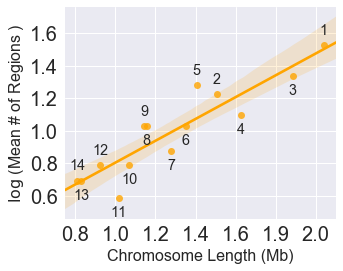

In [96]:
fig, ax = plt.subplots(1,1,figsize=(5,4));
sns.set(font_scale=1.2)
rp = sns.regplot(x="Chrlen",y="LogEN",data=log_allele_df,color='orange');#rp.axes.set_ylim(0,)#rp.axes.set_xlim(0,)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0,0.8,1.0,1.2,1.4,1.6,1.9,2.0,2.2];
ax.set_xticklabels(labels);
##plt.ylabel("$\log$ $E$ [ # of Haplotypes ]",fontsize=16);
plt.ylabel("$\log$ (Mean # of Regions )",fontsize=16);
plt.xlabel('Chromosome Length (Mb)',fontsize=16);
for ch,clen in enumerate(clens):
    if ch in [0,1,4,8,11,13]:#ch % 2 == 0:
        I = 0.09
        rp.annotate(str(ch+1),
                       (clen,
                        float(log_allele_df.LogEN[
                                              (log_allele_df.Chrom==chrlist[ch])]) + I),
                     horizontalalignment='center',verticalalignment='center');
    else:
        I = -0.09
        rp.annotate(str(ch+1),
                       (clen,
                        float(log_allele_df.LogEN[
                                              (log_allele_df.Chrom==chrlist[ch])]) + I),
                     horizontalalignment='center',verticalalignment='center');
plt.tight_layout();
plt.savefig('../FIGS/Crypto-09-GW-LOH-Feb2018.png',dpi=1200);